In [1]:
%cd /src/HAI_Flask

/src/HAI_Flask


In [2]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # will suppress all warnings
import neuralgym as ng

from engine.deepfillv1.inpaint_model import InpaintCAModel
from engine.deepfillv1.inpaint_ops import flow_to_image_tf

from engine.utils import Namespace
from engine.utils import get_colormap_image

In [3]:
prefix = 'engine/testfiles'
args = Namespace(image = 'engine/input_image.png',
                 mask = 'engine/input_mask.png',
                 output =  prefix + '/output.png',
                 output_mask = prefix + '/output_mask.png',
                 output_coarse =  prefix + '/output_coarse.png',
                 output_fine =  prefix + '/output_fine.png',
                 output_flow =  prefix + '/output_flow.png',
                 output_modulated =  prefix + '/output_modulated.png',
                 flow_modulated =  prefix + '/output_flow_modulated.png',
                 checkpoint_dir = 'engine/deepfillv1/model_logs')
ng.get_gpus(1)

# gpu        pid  type    sm   mem   enc   dec   command
# Idx          #   C/G     %     %     %     %   name
    0          -     -     -     -     -     -   -              
    1          -     -     -     -     -     -   -              
    2          -     -     -     -     -     -   -              
    3          -     -     -     -     -     -   -              
    4          -     -     -     -     -     -   -              
    5          -     -     -     -     -     -   -              
    6          -     -     -     -     -     -   -              
    7          -     -     -     -     -     -   -              

Set env: CUDA_VISIBLE_DEVICES=[0].


[0]

Shape of image: (296, 560, 3)
Shape of mask: (296, 560, 3)
Shape of downsampled mask: (37, 70, 3)
Shape of restored mask: (296, 560, 3)
Shape of model input: (1, 296, 1120, 3)


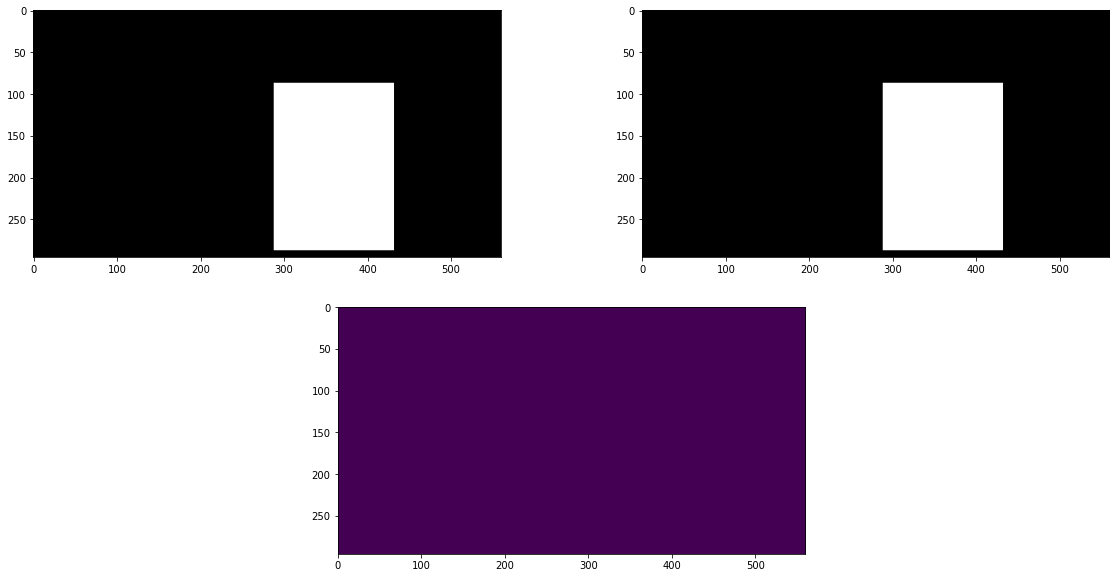

In [4]:
tf.reset_default_graph()
model = InpaintCAModel()
image = cv2.imread(args.image)
mask0 = cv2.imread(args.mask)

assert image.shape == mask0.shape
h0, w0, _ = image.shape
grid = 8
image = image[:h0//grid*grid, :w0//grid*grid, :]
mask0 = mask0[:h0//grid*grid, :w0//grid*grid, :]
h, w, _ = image.shape
print('Shape of image: {}'.format(image.shape))
print('Shape of mask: {}'.format(mask0.shape))

# quantize mask
dratio = 8
dw, dh = w // dratio, h // dratio
mask_downsampled = cv2.resize(mask0, dsize=(dw, dh), interpolation=cv2.INTER_NEAREST)
mask = cv2.resize(mask_downsampled, dsize=(w, h), interpolation=cv2.INTER_NEAREST)
print('Shape of downsampled mask: {}'.format(mask_downsampled.shape))
print('Shape of restored mask: {}'.format(mask.shape))
cv2.imwrite(args.output_mask, mask[:, :, ::-1])

image = np.expand_dims(image, 0)
mask = np.expand_dims(mask, 0)
input_image = np.concatenate([image, mask], axis=2)
print('Shape of model input: {}'.format(input_image.shape))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(221)
plt.imshow(mask0.astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(222)
plt.imshow(mask[0].astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(212)
err = (mask0 - mask[0]).astype(np.float) / 255
err = (err ** 2).sum(-1) ** 0.5
plt.imshow(err)
ax.set_aspect('equal')

In [5]:
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
with tf.Session(config=sess_config) as sess:
    input_image = tf.constant(input_image, dtype=tf.float32)
    output, flow, attention = model.build_server_graph(input_image)
    def toimg(t):
        t = (t + 1.) * 127.5
        t = tf.reverse(t, [-1])
        t = tf.saturate_cast(t, tf.uint8)
        return t
    output = toimg(output)
    flow = toimg(flow)
    # load pretrained model
    vars_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    assign_ops = []
    for var in vars_list:
        vname = var.name
        from_name = vname
        var_value = tf.contrib.framework.load_variable(args.checkpoint_dir, from_name)
        assign_ops.append(tf.assign(var, var_value))
    sess.run(assign_ops)
    print('Model loaded.')
    result, flow, attention = sess.run(output), sess.run(flow), sess.run(attention)
    
    result = np.array(result)
    result, coarse, fine = np.split(result, 3, axis=2)
    cv2.imwrite(args.output, result[0][:, :, ::-1])
    cv2.imwrite(args.output_coarse, coarse[0][:, :, ::-1])
    cv2.imwrite(args.output_fine, fine[0][:, :, ::-1])
    print('Shape of model output: {}'.format(result.shape))
    
    flow = np.array(flow)
    flow = cv2.resize(flow[0][:, :, ::-1], dsize=(w, h), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(args.output_flow, flow)
    print('Shape of model attention (colored): {}'.format(flow.shape))
    
    attention = np.array(attention)
    print('Shape of model attention (full): {}'.format(attention.shape))
    
print('Done')

Called: build_server_graph()
Shape of masked images: (1, 296, 560, 3)
Shape of masks: (1, 296, 560, 1)
Called: build_inpaint_net()
Shape of first-stage input: (1, 296, 560, 5)
Shape of first-stage output: (1, 296, 560, 3)
Shape of second-stage input: (1, 296, 560, 3)
Shape of second-stage conv branch output: (1, 74, 140, 128)
Shape of contextual attention input: (TensorShape([Dimension(1), Dimension(74), Dimension(140), Dimension(128)]), TensorShape([Dimension(1), Dimension(74), Dimension(140), Dimension(1)]))
Called: contextual_attention()
Shape of foreground features: (1, 74, 140, 128)
Shape of background features: (1, 74, 140, 128)
Shape of masks: (1, 74, 140, 1)
Shape of background patches (raw_w): (1, 4, 4, 128, 2590)
Shape of resized foreground features: (1, 37, 70, 128)
Shape of resized background features: (1, 37, 70, 128)
Shape of resized masks: (1, 37, 70, 1)
Shape of downscaled background patches (w): (1, 37, 70, 1152) (ksize 3, stride 1)
Shape of downscaled background patch

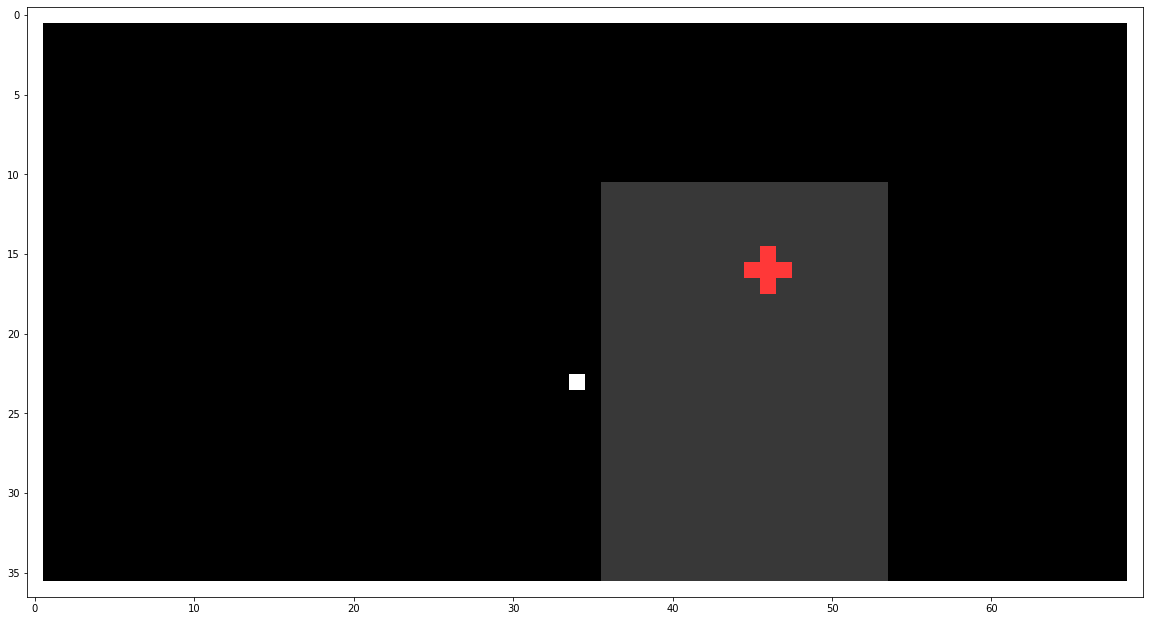

In [6]:
attention = np.array(attention)
bs, height, width, hw = attention.shape
assert height * width == hw
att_reshaped = np.reshape(attention, [bs, height, width, height, width])
att_mask = cv2.resize(mask[0][..., -1], dsize=(width, height), interpolation=cv2.INTER_NEAREST)
hidx, widx = np.nonzero(att_mask)
hpos, wpos = hidx[100], widx[100]

# mask and show maximum
att_img = att_reshaped[0][hpos, wpos]
att_img = att_img * (1 - att_mask.astype(np.int32))
att_img = (att_img / att_img.max() * 255).astype(np.uint8)
# overlay mask
att_img = att_img * (1 - att_mask) + 200 * att_mask
# cast to RGB
att_img = np.tile(np.reshape(att_img, [height, width, 1]), [1, 1, 3])
# crosshair
att_img[hpos, wpos-1:wpos+2, 0] = 255
att_img[hpos-1:hpos+2, wpos, 0] = 255
att_img[0, :, :] = 255
att_img[-1, :, :] = 255
att_img[:, 0, :] = 255
att_img[:, -1, :] = 255
# show
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
plt.imshow(att_img.astype(np.float) / 255)
ax.set_aspect('equal')
#cv2.imwrite('test_attention.jpg', att_img[:, :, ::-1])